In [40]:
#Setup
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

g = pd.read_csv("audl_elo.csv") #  is short for games table
g.tail()

,gameorder,game_id,_iscopy,year_id,date,seasongame,is_playoffs,team_id,fran_id,pts,elo_i,elo_n,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast
1847,924,201805200TOR,1,2018,05/20/2018,5,0,OTT,Outlaws,19,1398.537848,1396.488906,TOR,Rush,21,1699.981325,1702.030267,A,L,0.108741
1848,925,201805200MTL,0,2018,05/20/2018,6,0,MTL,Royal,21,1498.119751,1505.239589,DC,Breeze,20,1570.244913,1563.125075,H,W,0.488309
1849,925,201805200MTL,1,2018,05/20/2018,7,0,DC,Breeze,20,1570.244913,1563.125075,MTL,Royal,21,1498.119751,1505.239589,A,L,0.511691
1850,926,201805200DAL,0,2018,05/20/2018,6,0,DAL,Roughnecks,26,1661.624444,1668.101087,ATL,Hustle,21,1485.316676,1478.840033,H,W,0.799524
1851,926,201805200DAL,1,2018,05/20/2018,7,0,ATL,Hustle,21,1485.316676,1478.840033,DAL,Roughnecks,26,1661.624444,1668.101087,A,L,0.200476


## Looking at Regular Season Win Percentage Distribution

I split the games by team and season to get season win percentages for each team, then plot these to see the distribution.

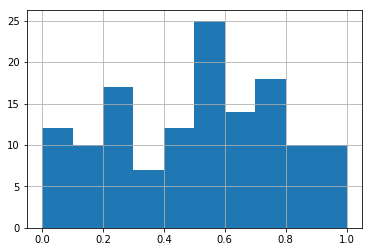

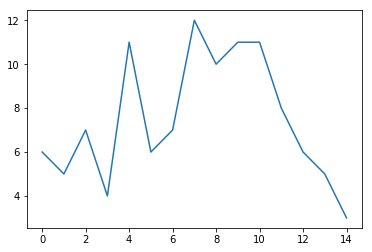

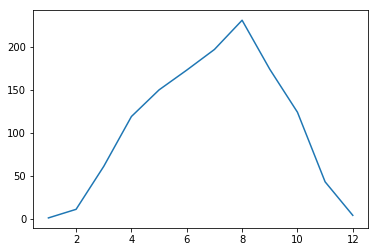

In [46]:
def calc_win_percentage(column):    
    counts = column.value_counts()
    if 'W' in counts:
        win_percentage = counts['W']/len(column)
    else:
        win_percentage = 0
    return win_percentage

def calc_num_wins(column):
    counts = column.value_counts()
    if 'W' in counts:
        wins = counts['W']
    else:
        wins = 0        
    return wins

def calc_num_wins_round(column):
    counts = column.value_counts()
    if 'W' in counts:
        win_percentage = counts['W']/len(column)
    else:
        win_percentage = 0
    wins = round(win_percentage * 14)
    return int(wins)

def plot_win_percentage_histogram(elo_table = g,years_list = [],bins_=10):
    split = elo_table[elo_table['is_playoffs'] == 0].groupby(['year_id','fran_id'])

    win_percentages = split["game_result"].agg(calc_win_percentage)
    if years_list:
        t = win_percentages.loc[years_list]
    else:
        t = win_percentages
    t.hist(bins=bins_)
    plt.show()
    
def plot_number_of_wins(elo_table = g, years_list = [], bins_ = 10):
    split = elo_table[elo_table['is_playoffs'] == 0].groupby(['year_id','fran_id'])

    wins = split["game_result"].agg(calc_num_wins_round)
    if years_list:
        t = wins.loc[years_list]
    else:
        t = wins
    
    t.value_counts(sort = False).plot()
    plt.show()
    
    
plot_win_percentage_histogram()
plot_number_of_wins(years_list = range(2012,2018))
plot_number_of_wins(nba_g,years_list = range(1968,2016))

## Predictive Ability of Current Elo Algorithm

The predictive ability seems to be off a bit as we can see by these numbers.

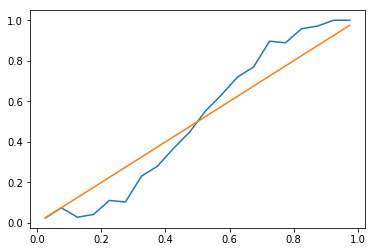

In [42]:
def plot_win_percentage_brackets(elo_table = g,year_list = [],bins=20):
    ranges = bins
    desired_win_percentages = []
    actual_win_percentages = []
    for i in range(ranges):
        low = i/ranges
        high = (i+1)/ranges
        if year_list:
            years_g = elo_table[elo_table['year_id'].isin(year_list)]
        else:
            years_g = elo_table
        target_games = years_g[(years_g['forecast'] <= high) & (years_g['forecast'] > low)]
        target_counts = target_games['game_result'].value_counts()
        if 'W' in target_counts:
            win_percent = target_counts['W']/len(target_games)
        else:
            win_percent = i/ranges+.5/ranges
        desired_win_percentages.append(i/ranges+.5/ranges)
        actual_win_percentages.append(win_percent)
        #print(str(100*i/ranges+50/ranges),"% Bracket : ", win_percent, "     Count:",len(target_games))
    plt.plot(desired_win_percentages,actual_win_percentages)
    plt.plot(desired_win_percentages,desired_win_percentages)
    plt.show()
    
    
plot_win_percentage_brackets()

## Analysis 

The last two sections seem to indicate that our current model doesn't have great predictive value of the outcome of games. The second graph shows that good teams are better (win more often) than our model predicts and bad teams are worse (lose more often) than our model predicts. 

We can see from the first graph that, if we use the regular season win percentage as a proxy for how good a team is, teams in the AUDL may not be distributed normally (actually logistically) distributed in skill as would be needed for the current Elo Algorithm to work. However, there may be other problems we should rule out first.
1. Our numbers are wrong
    1. The k value (20) is wrong.
    2. Our update function based on margin of victory and point differential is wrong.
    3. Our Year-to-Year elo point carryover is wrong (currently 2/3 of previous years elo).
2. There isn't enough data - the league hasn't played enough games yet.
3. The talent of teams is not distributed normally.

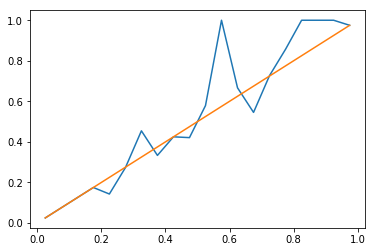

In [43]:
plot_win_percentage_brackets(year_list=[2018],bins=20)

In [ ]:
## Comparison with NBA
nba_g = pd.read_csv("nbaallelo.csv") #dataset from fivethirtyeight

plot_win_percentage_histogram(nba_g,range(1970,1980),bins_=10)
plot_win_percentage_brackets(nba_g)

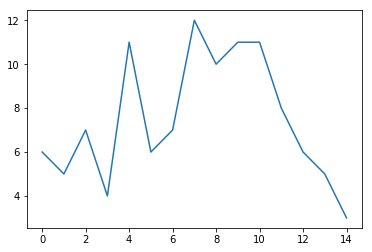

In [45]:
elo_table = g.copy()
years_list = [2012,2013,2014,2015,2016,2017]
bins_=10

split = elo_table[elo_table['is_playoffs'] == 0].groupby(['year_id','fran_id'])

wins = split["game_result"].agg(calc_num_wins_round)
if years_list:
    t = wins.loc[years_list]
else:
    t = wins

t.value_counts(sort = False).plot()